# Circuit implementation of Order Finding and Shor's algorithm using TheQ

This notebook will teach you how to construct your own circuits for Order Finding and Shor's algorithm using TheQ.

# Importing packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
import numpy as np # For playing around with pi
import matplotlib.pyplot as plt # For plotting functions
from google.colab import files
#req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str = 'http://187c37408942.ngrok.io/qsim/perform_operation'
#req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'
req_str_qasm = 'http://187c37408942.ngrok.io/qsim/qasm'

# Required functions

These are some required functions to run any circuit in TheQ

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']

def Toffoli(q0, q1, q2):
  gate(reg_id, 'hadamard', {'q': q2})
  gate(reg_id, 'cnot', {'q_control': q1, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': -np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q1, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q1, 'theta': np.pi/4})
  gate(reg_id, 'zrot', {'q': q2, 'theta': -np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q1})
  gate(reg_id, 'zrot', {'q': q1, 'theta': np.pi/4})
  gate(reg_id, 'hadamard', {'q': q2})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q1})
  gate(reg_id, 'zrot', {'q': q0, 'theta': -np.pi/4})
  gate(reg_id, 'zrot', {'q': q1, 'theta': -np.pi/2})


# Order Finding algorithm

We start with the circuit of the Order Finding algorithm, which is the quantum subroutine in the famous Shor's algorithm. This algorithm is used to compute the order of the function $f(x) = a^{x} \text{ mod } N$, that is, an $r \in \mathbb{N}$ such that $f(r) = a^{r} \text{ mod }N = 1$. This can also be seen as finding the period of the periodic function $f$. The idea is to use Quantum Phase Estimation on the operator 

\begin{equation}
  U|x\rangle = |ax \text{ mod }N \rangle
\end{equation}

with $|1\rangle$ prepared in the register where usually an eigenvector is prepared. In our examples, we will be using $2$ qubits for precision and hence the circuit will look like this

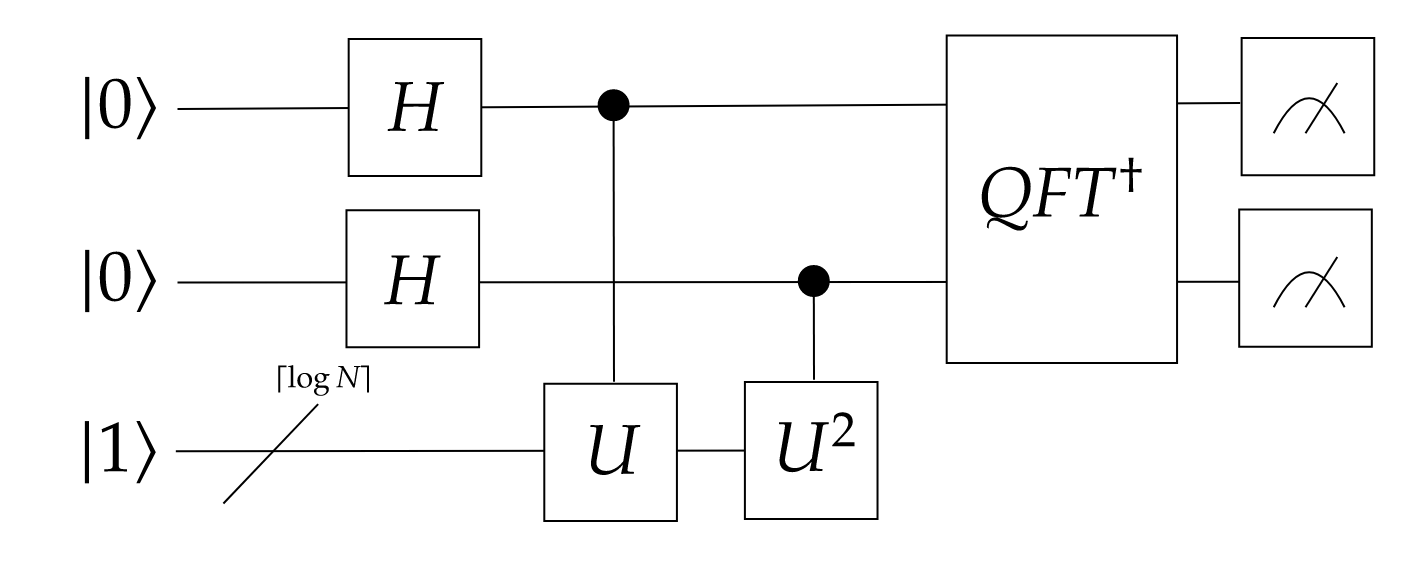

The measurement output gives us the value $\frac{s}{r}$. From this outout, we use continued fraction to get the value of $r$.

In this example, we will be carrying out Order finding for $a = 7$ and $N = 15$. So, we are going to compute the order of the function $f(x) = 7^x \text{ mod }15$. The circuit for the required unitary $U$ is

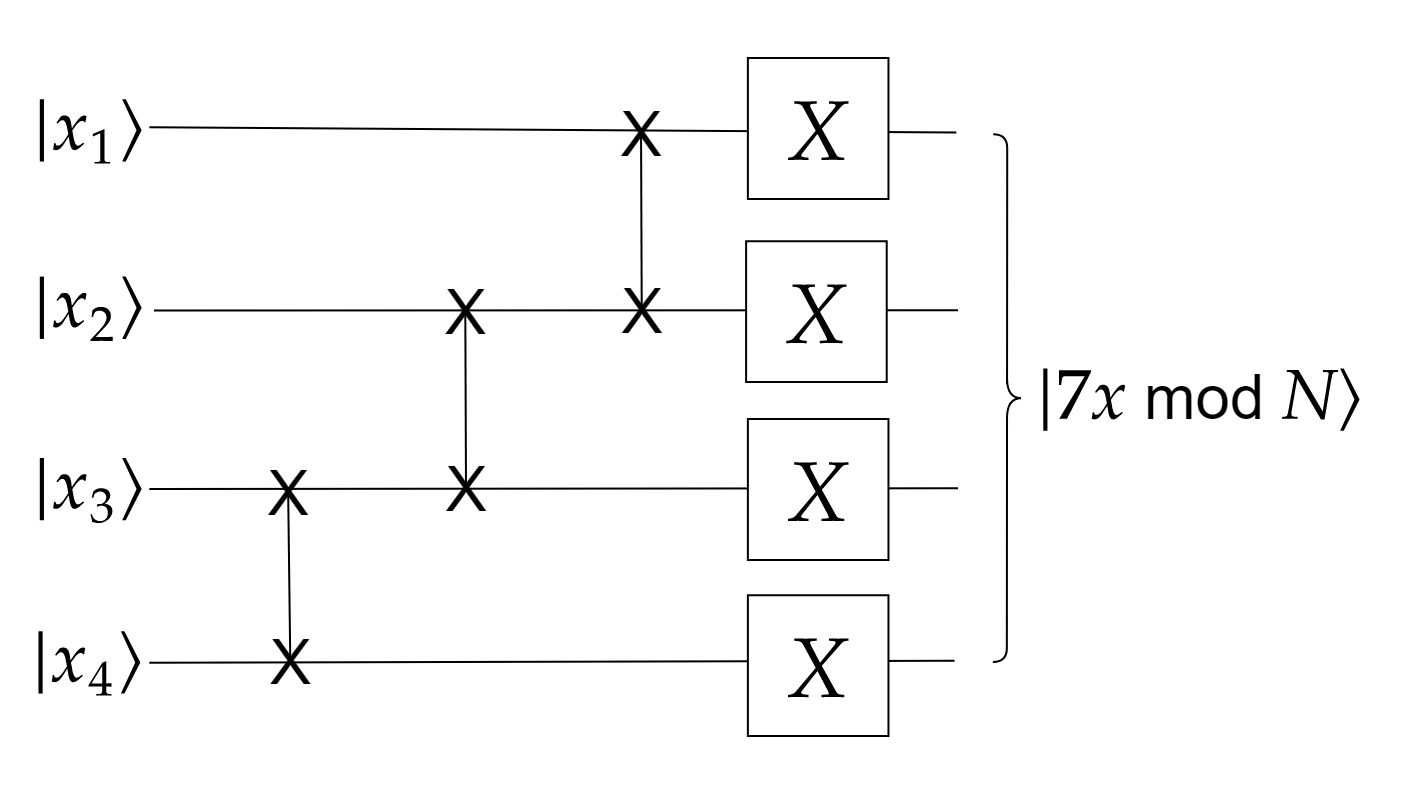

where $x = x_1 x_2 x_3 x_4$.



Note that this is not the kind of unitary that gives an algorithm which has complexity polynomial in $j$. To achieve that, one should simulate classical repeated squaring on a quantum computer, which is always possible. But, for demonstration purpose, we'll use this circuit. For more details regarding preparing oracles, we refer the reader to https://qiskit.org/textbook/ch-algorithms/shor.html. To apply this gate in a controlled manner, we replace each $SWAP$ gate with controlled-$SWAP$ gate and each $X$ gate by $CNOT$ gates, all controlled on the required control qubit.

Since $N = 15$, there are $15$ possible outputs to this function and hence $4$ qubits are required in the last register of the circuit. Therefore the final circuit that we have to simulate would look like this

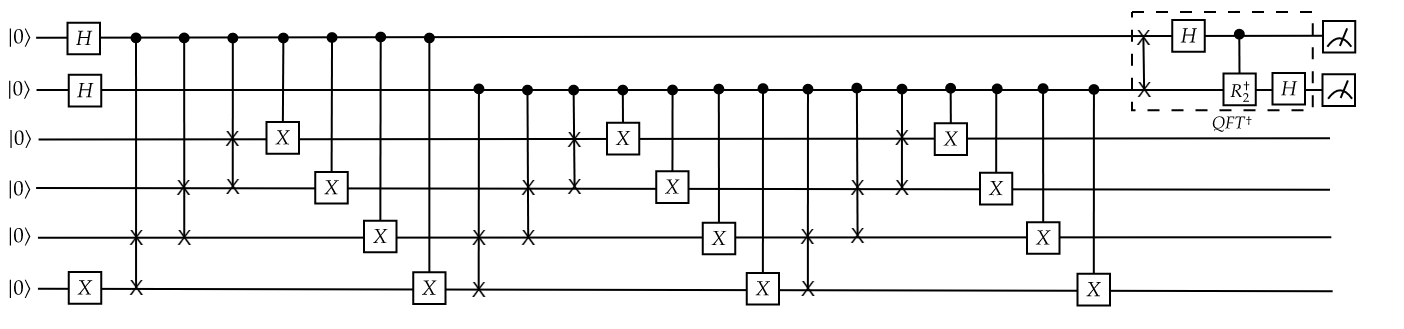

Now, we move on to constructing this circuit using TheQ.

Since the circuit contains $6$ qubits, we create a circuit with $6$ qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(6,0)

Now, we shall start applying the gates.

Apply Hadamard gates on first $2$ qubits

In [ ]:
# Apply Hadamard gate on first 2 qubits
for i in range(2):
  gate(reg_id, 'hadamard', {'q': i})

Apply $X$ gate on the last qubit to prepare $|1\rangle$ on the second register.

In [ ]:
# Apply X gate on the last qubit
gate(reg_id, 'X', {'q': 5})

Now, we shall start applying controlled-$U ^ {2 ^ j}$ gates.

In [ ]:
# Apply controlled-U gates
for control_qubit in range(2):
  for k in range(2 ** control_qubit):
    # Apply Fredkin gate 
    gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})
    Toffoli(control_qubit,4,5)
    gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})

    # Apply Fredkin gate
    gate(reg_id, 'cnot', {'q_control': 4, 'q_target': 3})
    Toffoli(control_qubit,3,4)
    gate(reg_id, 'cnot', {'q_control': 4, 'q_target': 3})
    
    # Apply Fredkin gate
    gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 2})
    Toffoli(control_qubit,2,3)
    gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 2})

    for j in range(2,6):
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': j})

The next part is the inverse quantum Fourier transform part.

In [ ]:
# Apply swap gates
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 0})
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

# Apply controlled-Rk inverse gates
for target_qubit in range(2):
  for control_qubit in range(target_qubit):
    gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
  gate(reg_id, 'hadamard', {'q': target_qubit})

Now that we have explained the construction of the circuit, we simulate the circuit $100$ times and analyze the result.

In [ ]:
# Apply the previously constructed circuit.
destroy_circuit(reg_id)

In [ ]:
k = 0
results = {}

In [ ]:
while sum([results[key] for key in results]) < 100:
  # Prepare the circuit
  reg_id = create_circuit(6,0)

  # Apply Hadamard gate on first 2 qubits
  for i in range(2):
    gate(reg_id, 'hadamard', {'q': i})

  # Apply X gate on the last qubit
  gate(reg_id, 'X', {'q': 5})

  # Apply controlled-U gates
  for control_qubit in range(2):
    for k in range(2 ** control_qubit):
      # Apply Fredkin gate 
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})
      Toffoli(control_qubit,4,5)
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})

      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 4, 'q_target': 3})
      Toffoli(control_qubit,3,4)
      gate(reg_id, 'cnot', {'q_control': 4, 'q_target': 3})
      
      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 2})
      Toffoli(control_qubit,2,3)
      gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 2})

      for j in range(2,6):
        gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': j})

  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(2):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(1,-1,-1))})

  destroy_circuit(reg_id)

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1

  

99
100


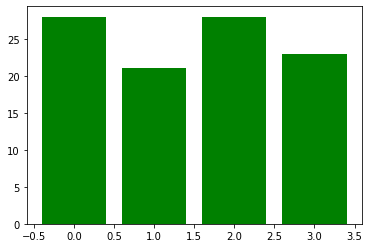

In [ ]:
# Plot the results 
plt.bar(results.keys(), results.values(), color='g')
plt.show()

From the histogram, we can see that there are $4$ equally likely outputs. Let's convert these outputs to decimal values and carry out continued fraction on them.

In [ ]:
# Apply continued fraction on the output
for key in results:
  print(Fraction(key/4))

We can see that possible values are $4$ and $2$. Since $4$ occurred the most, we go with $4$. To verify if $4$ is indeed the period of our function, we shall plot $f$ on a graph

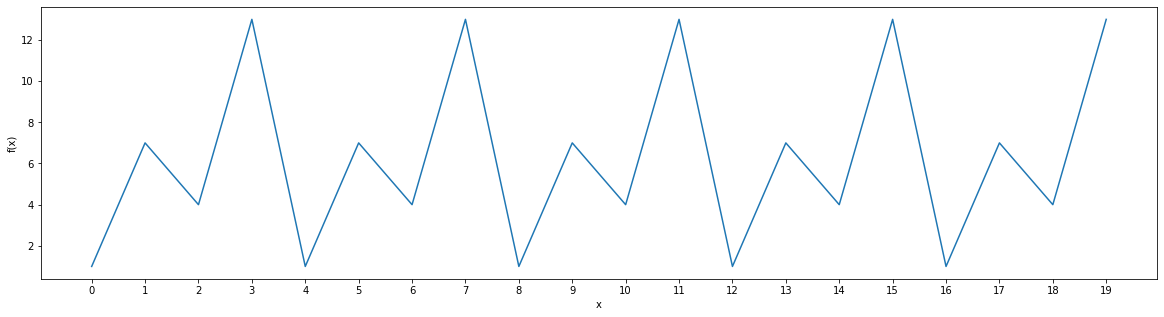

In [ ]:
# Plot f
x = list(range(20))
y = [(7 ** k) % 15 for k in x]
f =plt.figure()
plt.plot(x, y)
f.set_figwidth(20)
f.set_figheight(5)

plt.xticks(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

From the graph, it is evident that $4$ is indeed the period of the function $f$.

# Shor's algorithm for factoring

In this section, we shall implement Shor's algorithm to factorize the number $15$. Shor's algorithm can be used to compute a prime factor of any number $N$.

1. Check if a prime factor of $N$ can be easily computed. (Prime number, power of prime number, even number)
2. If not, randomly choose a number $a$ from $1, \dots, N$. If $\text{gcd}(a,N) > 1$, return $a$.
3. Use quantum order finding algorithm to find $r$ such that $a^r \text{ mod } N = 1$,
4. If $r$ is even and $a ^ {\frac{r}{2}} \text{ mod } N \neq N - 1$, then compute $\text{gcd}(a ^{\frac{r}{2}}-1,N)$ and $\text{gcd}(a ^{\frac{r}{2}}+1,N)$.
5. If anyone of them is a non-trivial factor of $N$, then return it, otherwise abort.

Since $15$ is not elligible for any of the available classical algorithms, we can move past Step 1. Since we have already carried out order finding for $a =7$ and $N = 15$, we shall choose $7$ in Step $2$. We have already found the order to be $4$. Now, we shall carry out Step $4$. Since $7^2 \text{ mod }N = 4 \neq 14$, we can compute the required gcds. 

In [ ]:
# Compute gcd(48,15)
x = 48
y = 15
while y:
  x, y = y, x % y

print("gcd of 48 and 15 is: {}".format(x))

gcd of 48 and 15 is: 3


$3$ is a prime factor of $15$. When we divide $15$ by $3$, we get the other prime factor $5$.

# Discrete Logarithm

In this section, we shall see how we can use Shor's algorithm circuit to solve a discrete logarithm problem. The problem is defined as follows:

Let $G = \langle g \rangle$ be a cyclic group generated by $g$. For any $b \in G$, find the smallest $\gamma$ such that $b = g ^ \gamma$.

Given a function $f: \mathbb{Z}_{|G|} \times \mathbb{Z}_{|G|} \rightarrow G$ given as $f(x,y) = g^x b^{-y}$. Then, given the unitary $U |x\rangle |y\rangle |0\rangle \rightarrow U |x\rangle |y\rangle |f(x,y)\rangle$, we can solve this problem, as a Hidden Subgroup Problem, using the circuit

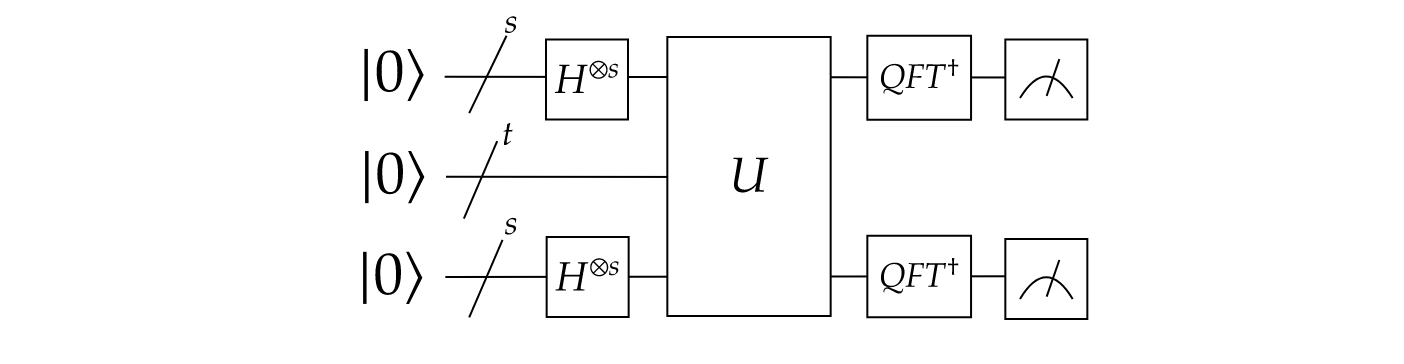

Here, $t$ is the number of qubits required to store elements of $G$ and $s = \log |G|$. The measurement output will be $(k, -k \gamma)$, where $k \in \mathbb{Z}_{|G|}$. If $-k$ admits a multiplicative inverse mod $|G|$, then we can compute $\gamma$. 





In our example, lets consider the group $G$ to be the group generated by $7$ under multiplication mod $15$. Then $G = \{ 7^0 = 1, 7^1 = 7, 7^2 = 4, 7^3 = 13\}$. We already know that the order of this group is $4$, from the previous section. Let $b = 4$, which means the $\gamma$ that we have to compute is $2$. Now, $U$ can be implented by the $U_{7}$ operator used in the previous section. Note that, when we implement $U_7$ in a controlled manner for phase estimation (the phase estimation circuit without the Hadamard gates and the inverse QFT), that gate implements the transformation $V$, where $V$ is given as $V |x_1\rangle |x_2\rangle |y\rangle = |x_1\rangle |x_2\rangle |7^{x_1 x_2} y \text{ mod }15\rangle$. So, applying $V$ twice implements the transformation $V^2 |x_1\rangle |x_2\rangle |y\rangle = |x_1\rangle |x_2\rangle |4^{x_1 x_2} y \text{ mod }15\rangle$ (Obviously, in reality you wouldn't know this because if you knew, that would be cheating! The actual algoritm is considered with the assumption that an oracle is provided for the transformation). Here $x_1x_2$ is a $2$-bit number in $\mathbb{Z}_4$.

Note that exponentiating by $-x_1x_2$ can be implemented by applying $V^2$ sandwiched by CNOT gates because $-0 = 0, -1 = 3, -2 = 2, -3 = 1$ in $\mathbb{Z}_4$. So, the final circuit will be

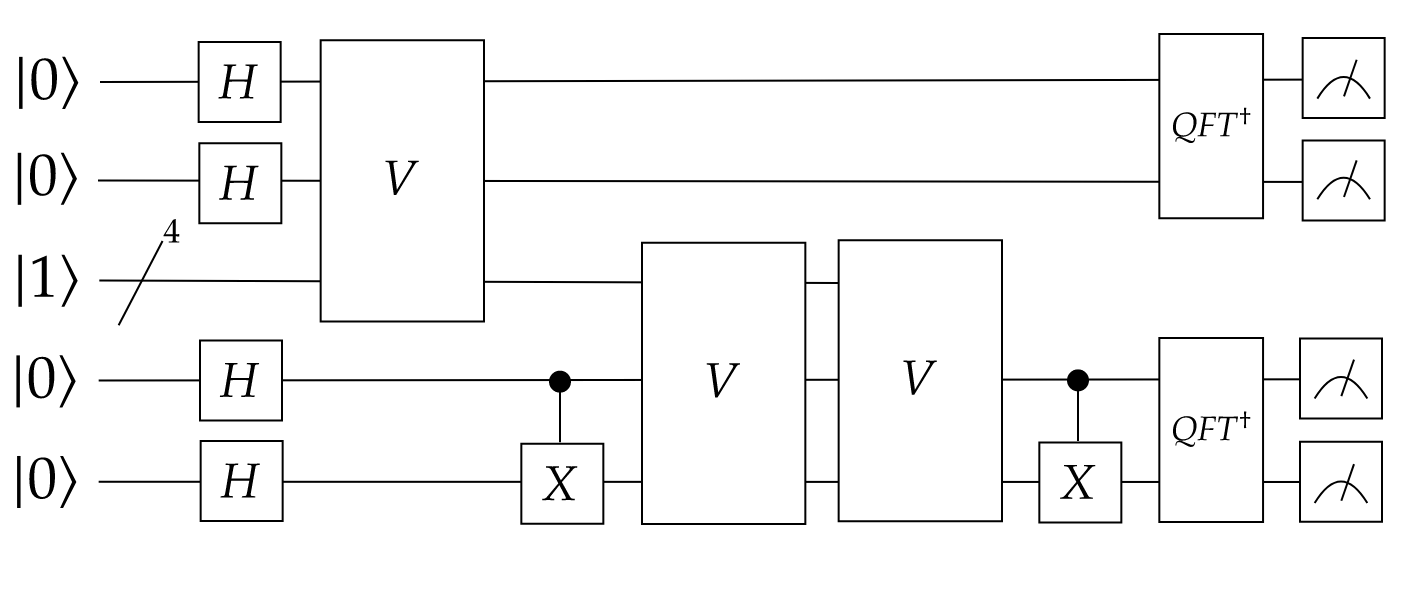


The possible outputs of this circuit should be, in $\mathbb{Z}_4$, $(0,0), (1, -1 \times 2 = 3 \times 2 = 2), (2,-2 \times 2 = 2 \times 2 = 0), (3,-3 \times 2 = 1 \times 2 = 2)$. Here, each tuple can be seen as (measurement result of top register, measurement result of bottom register).

In [ ]:
k = 0
results = {}

In [ ]:
while sum([results[key] for key in results]) < 15:

  # Prepare the circuit
  reg_id = create_circuit(8,0)

  # Apply Hadamard gate on first 2 qubits
  for i in range(4):
    gate(reg_id, 'hadamard', {'q': i})

  # Apply X gate on the last qubit
  gate(reg_id, 'X', {'q': 7})

  # Apply V

  for control_qubit in range(2):
    for k in range(2 ** control_qubit):
      # Apply Fredkin gate 
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})
      Toffoli(control_qubit,6,7)
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})

      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      Toffoli(control_qubit,5,6)
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      
      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})
      Toffoli(control_qubit,4,5)
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})

      for j in range(4,8):
        gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': j})

  # Apply V^2 with CNOTS

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})

  for control_qubit in range(2, 4):
    for k in range(2 ** (control_qubit - 2)):
      # Apply Fredkin gate 
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})
      Toffoli(control_qubit,6,7)
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})

      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      Toffoli(control_qubit,5,6)
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      
      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})
      Toffoli(control_qubit,4,5)
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})

      for j in range(4,8):
        gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': j})

  for control_qubit in range(2, 4):
    for k in range(2 ** (control_qubit - 2)):
      # Apply Fredkin gate 
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})
      Toffoli(control_qubit,6,7)
      gate(reg_id, 'cnot', {'q_control': 7, 'q_target': 6})

      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      Toffoli(control_qubit,5,6)
      gate(reg_id, 'cnot', {'q_control': 6, 'q_target': 5})
      
      # Apply Fredkin gate
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})
      Toffoli(control_qubit,4,5)
      gate(reg_id, 'cnot', {'q_control': 5, 'q_target': 4})

      for j in range(4,8):
        gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': j})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})

  # Apply inverse QFT

  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(2):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})


  # Apply inverse QFT

  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 2})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(2, 4):
    for control_qubit in range(2, target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(4))})

  destroy_circuit(reg_id)

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1




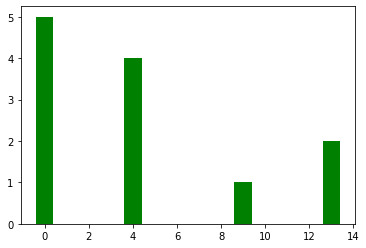

In [104]:
# Plot the results 
plt.bar(results.keys(), results.values(), color='g')
plt.show()

The outputs correspond to the expected output. The terms which have multiplicative inverses are $1$ and $3$. From these values, we can compute $\gamma$ to be $2$.